In [1]:
from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
from IPython.display import clear_output
import datetime as dt
import getpass
import graphviz
import hyperopt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
from sklearn import preprocessing
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 5
warnings.filterwarnings('ignore')

## Data load

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [3]:
max(df.Date)

Timestamp('2020-09-26 00:00:00')

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66234 entries, 0 to 66233
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  20169 non-null  object        
 1   Country/Region  66234 non-null  object        
 2   Lat             66234 non-null  float64       
 3   Long            66234 non-null  float64       
 4   Date            66234 non-null  datetime64[ns]
 5   Confirmed       66234 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.0+ MB


In [5]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(66234, 6)

In [6]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [7]:
sum(df.Confirmed.loc[(df.Country == 'Worldwide')&(df.Date == '2020-09-25') ])

32476713

In [8]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep='first')
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
689,716,ZW,ZWE,716.00,nan,NaN,NaN,Zimbabwe,-19.02,29.15,Zimbabwe,14862927.00
690,36,AU,AUS,36.00,nan,NaN,NaN,Australia,-25.00,133.00,Australia,25459700.00
699,124,CA,CAN,124.00,nan,NaN,NaN,Canada,60.00,-95.00,Canada,37855702.00
715,156,CN,CHN,156.00,nan,NaN,NaN,China,30.59,114.31,China,1404676330.00


In [9]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Province,Country,Lat,Long,Date,Confirmed,Country_Region,iso2
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0,Afghanistan,AF
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,AL
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,DZ
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,AD
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,AO
...,...,...,...,...,...,...,...,...
66478,NaN,Worldwide,nan,nan,2020-09-22,31516787,NaN,NaN
66479,NaN,Worldwide,nan,nan,2020-09-23,31779835,NaN,NaN
66480,NaN,Worldwide,nan,nan,2020-09-24,32141225,NaN,NaN
66481,NaN,Worldwide,nan,nan,2020-09-25,32476713,NaN,NaN


In [10]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

In [11]:
df_missing_continents = df.copy()
df_missing_continents = pd.DataFrame(df_missing_continents.groupby(['Date','Continent'])['Confirmed'].sum())
df_missing_continents.reset_index(inplace=True)  
df_missing_continents['Country'] = df_missing_continents['Continent']
df_missing_continents = df_missing_continents[df_missing_continents.columns.difference(['Continent'])]
df = df.append(df_missing_continents)

In [12]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [13]:
df = df[df.columns.difference(['Lat','Long'])]
df = df.drop_duplicates(subset=['Province_and_country','Date'])
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country']).cumcount()+1

In [14]:
df = df.reset_index(drop=True)

In [15]:
df.head()

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,NaN,Afghanistan,AF,1
1,0,Europe,Albania,Albania,2020-01-22,NaN,Albania,AL,1
2,0,Africa,Algeria,Algeria,2020-01-22,NaN,Algeria,DZ,1
3,0,Europe,Andorra,Andorra,2020-01-22,NaN,Andorra,AD,1
4,0,Africa,Angola,Angola,2020-01-22,NaN,Angola,AO,1


In [16]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68226 entries, 0 to 68225
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Confirmed                   68226 non-null  int64         
 1   Continent                   66483 non-null  object        
 2   Country                     68226 non-null  object        
 3   Country_Region              66234 non-null  object        
 4   Date                        68226 non-null  datetime64[ns]
 5   Province                    20169 non-null  object        
 6   Province_and_country        68226 non-null  object        
 7   iso2                        65487 non-null  object        
 8   Days_since_outbreak_global  68226 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 4.7+ MB


In [17]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [18]:
len(df['Province_and_country'].unique())

274

In [19]:
len(df['Country'].unique())

196

In [20]:
len(df['Province'].unique())

82

In [21]:
df.describe()

,Confirmed,Days_since_outbreak_global
count,68226.00,68226.00
mean,102323.82,125.00
std,947878.10,71.88
min,0.00,1.00
25%,14.00,63.00
50%,384.00,125.00
75%,4303.00,187.00
max,32751412.00,249.00


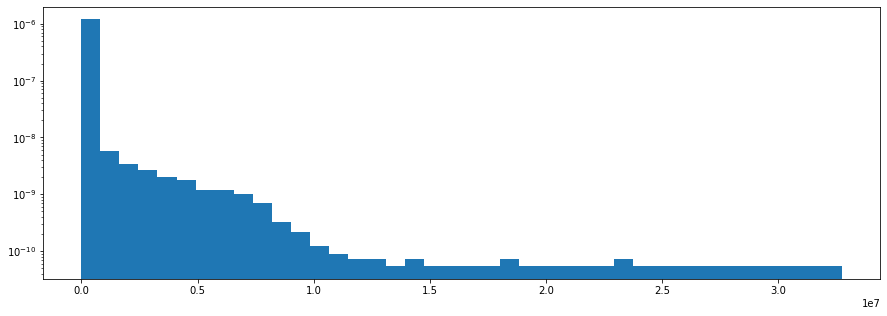

In [22]:
plt.hist(df['Confirmed'], density=True, bins=40) 
plt.yscale('log')

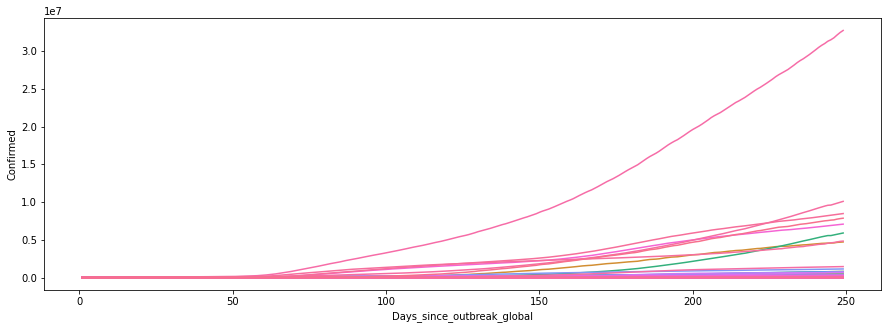

In [23]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

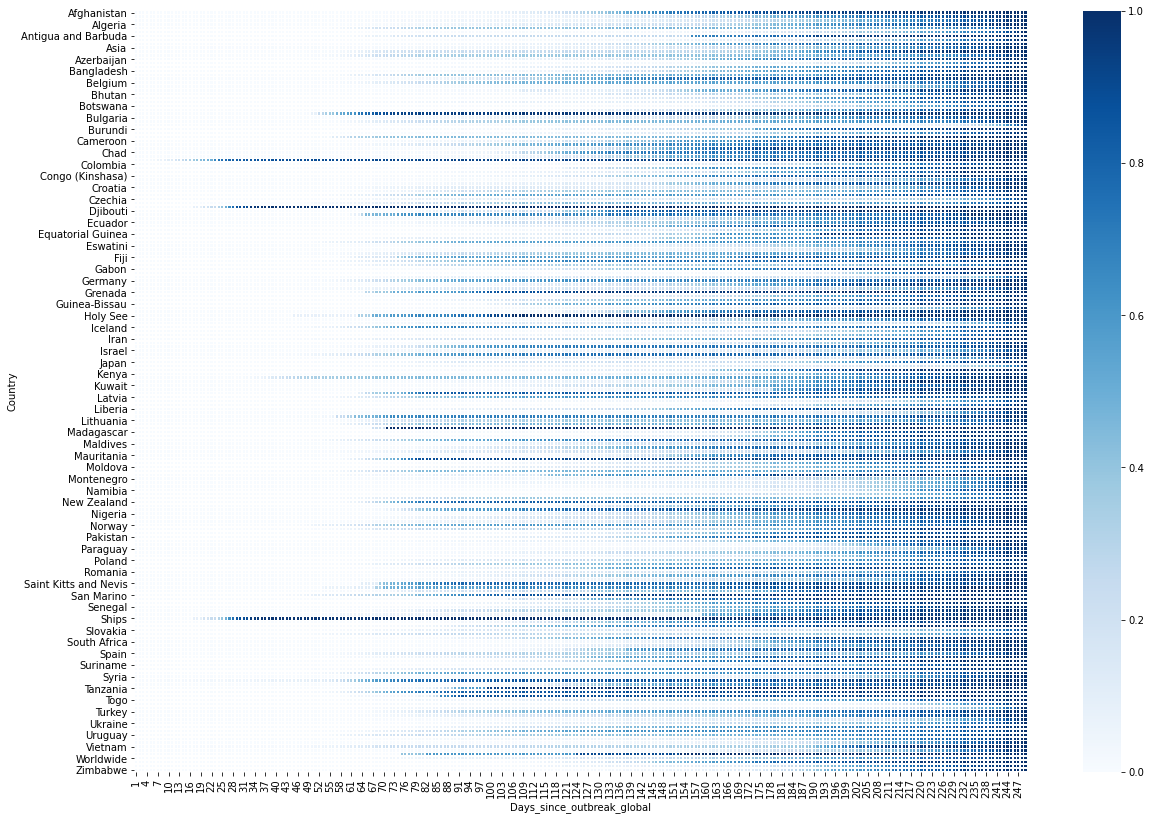

In [31]:
def group_and_chart(Geography, Figure, Data):
    grouped = Data.copy()
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped = pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped = grouped.pivot(index=Geography, columns='Days_since_outbreak_global', values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    min_max_scaler = preprocessing.MinMaxScaler()
    grouped_temp = min_max_scaler.fit_transform(grouped)
    grouped = pd.DataFrame(grouped_temp, index=grouped.index, columns=grouped.columns)
    grouped = grouped.transpose()
    rcParams['figure.figsize'] = 20, 14
    sns.heatmap(grouped, cmap="Blues", linewidth=.5)
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

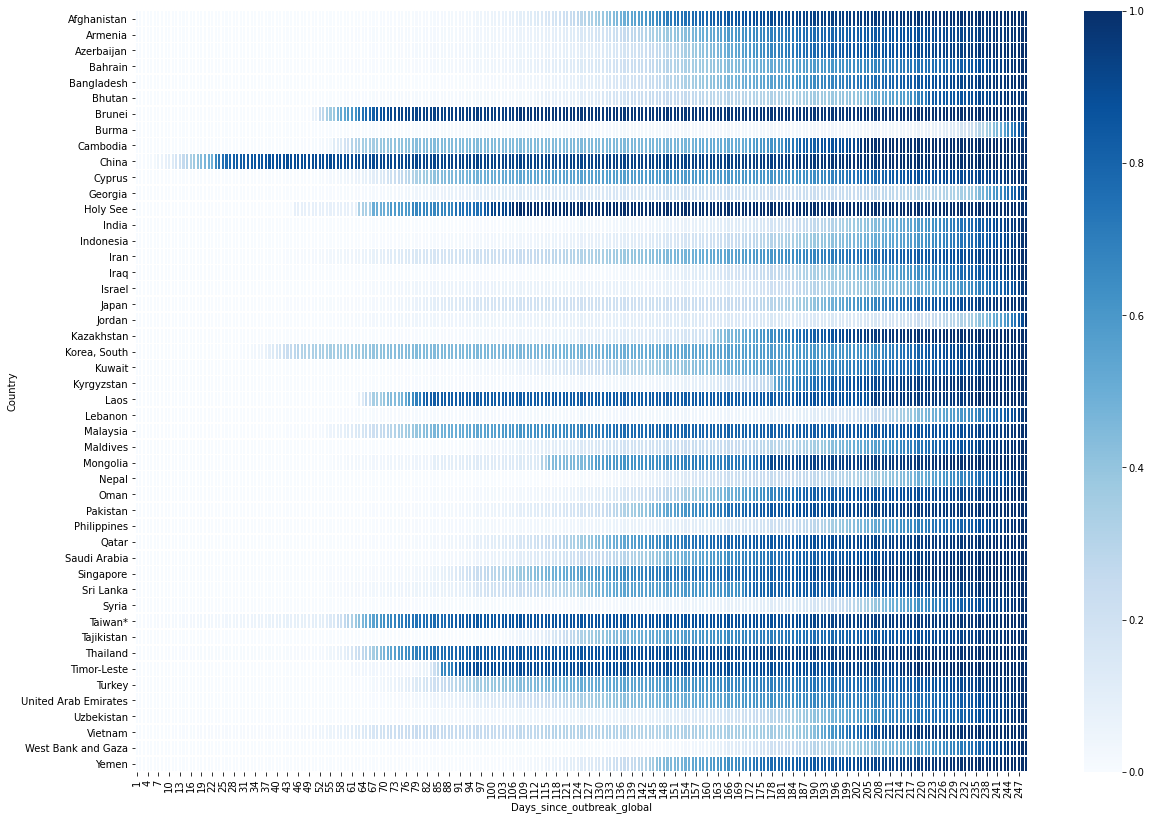

In [32]:
df_ = df.copy()
df_ = df_.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

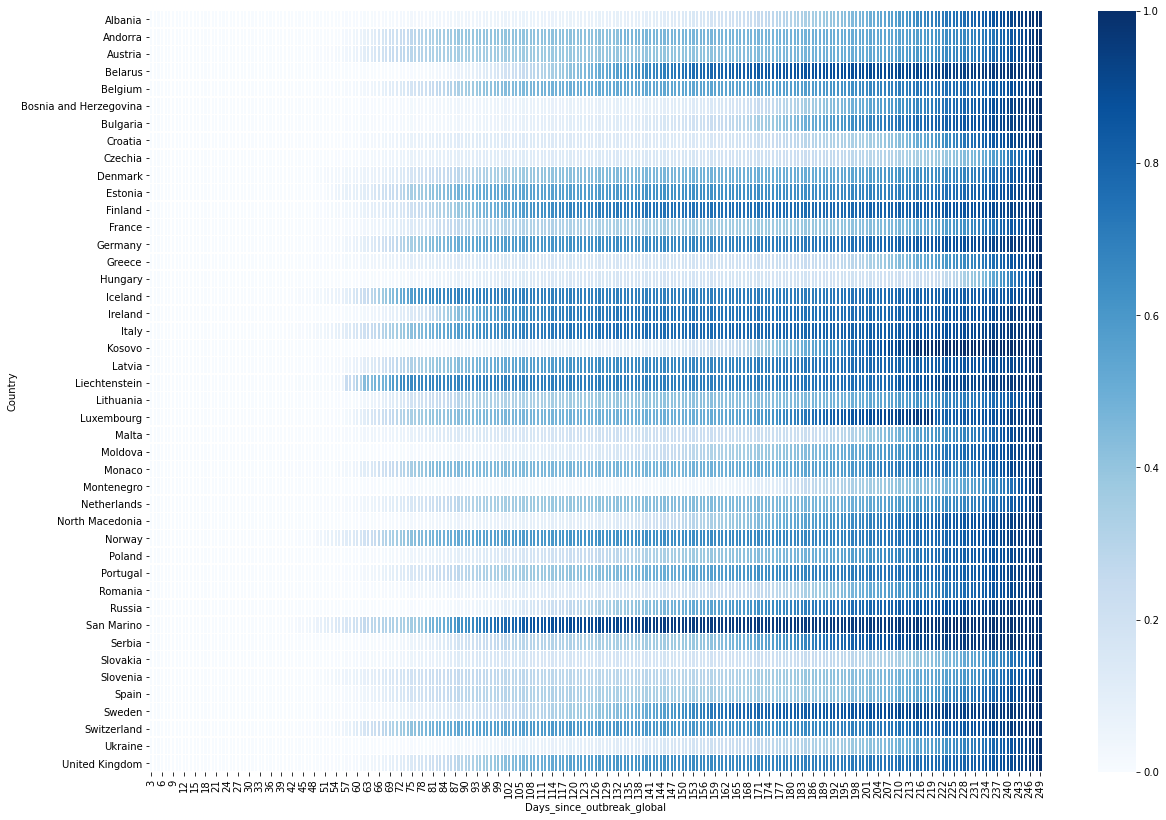

In [33]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

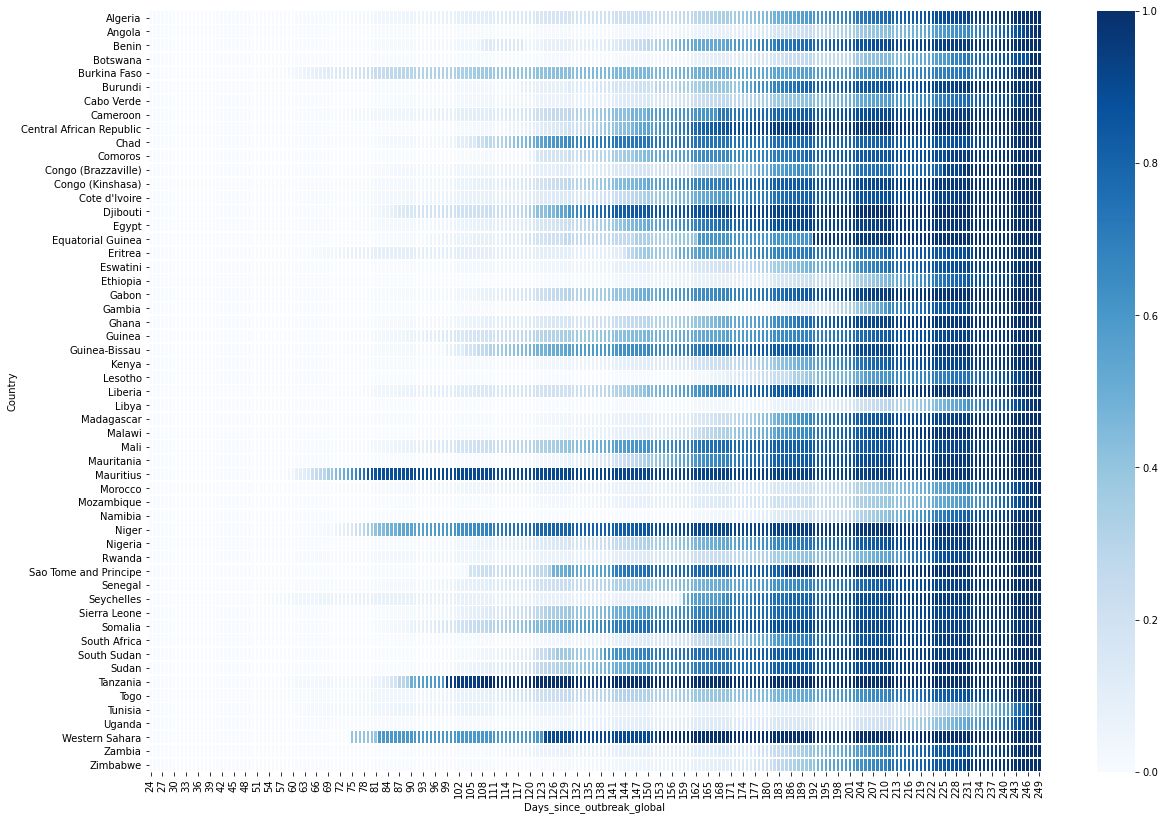

In [34]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

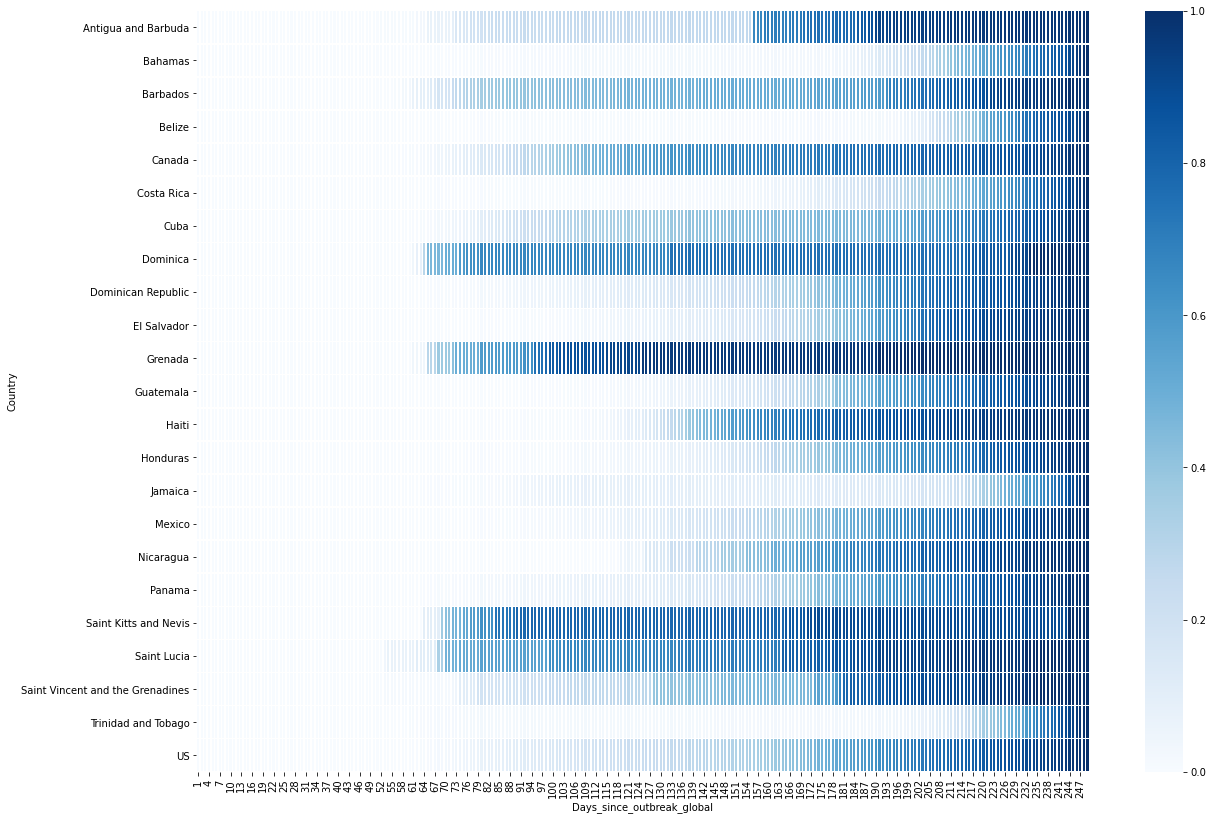

In [35]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

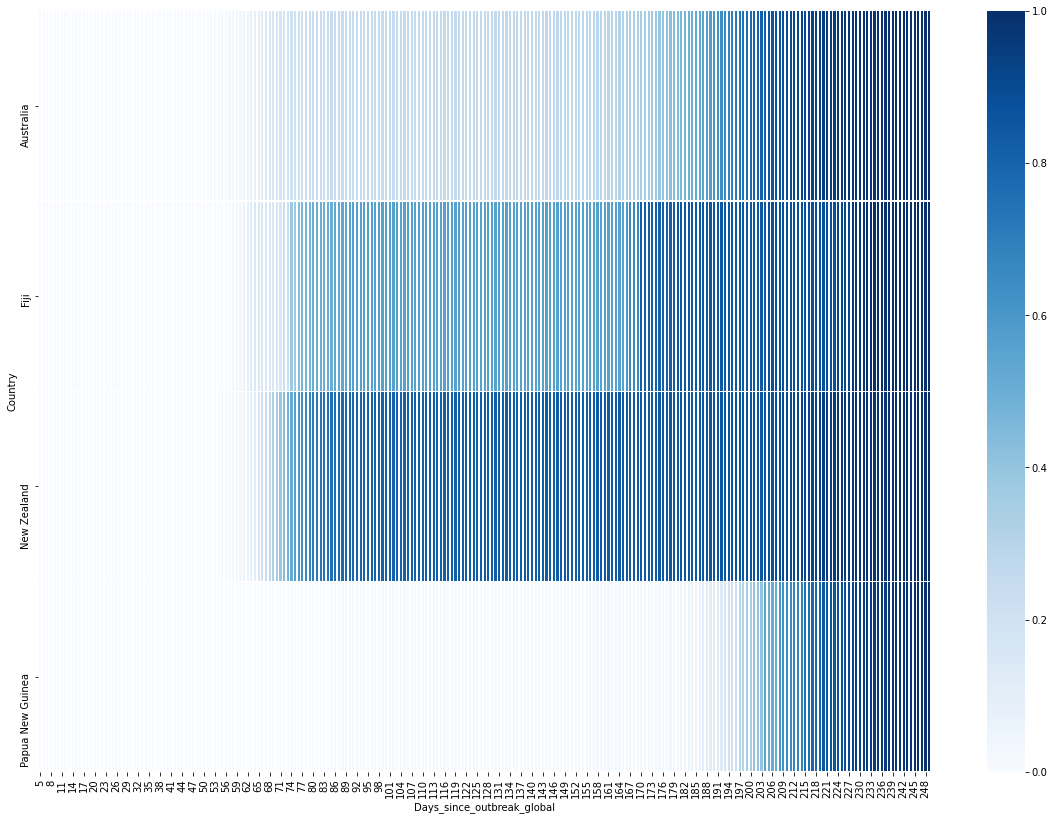

In [36]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

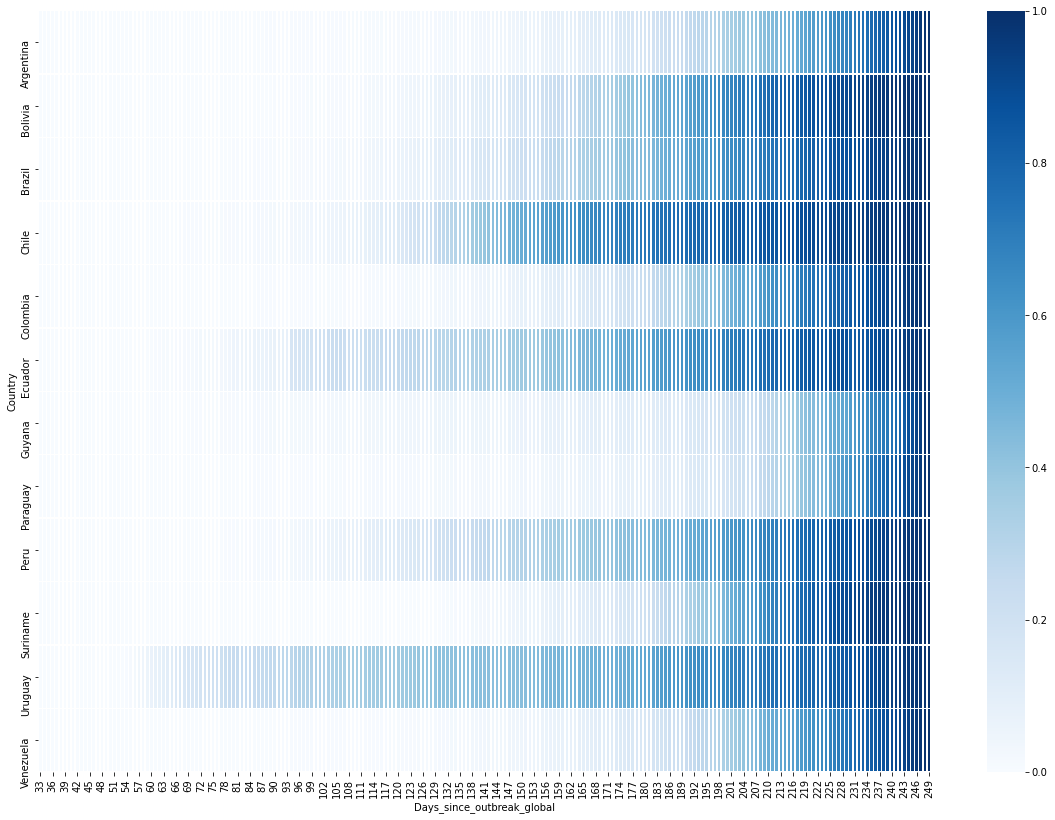

In [37]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [38]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,0,Afghanistan,AF,1,22,2,4,1,1,2020,0.00,0.00
1,0,Europe,Albania,Albania,2020-01-22,0,Albania,AL,1,22,2,4,1,1,2020,0.00,0.00
2,0,Africa,Algeria,Algeria,2020-01-22,0,Algeria,DZ,1,22,2,4,1,1,2020,0.00,0.00
3,0,Europe,Andorra,Andorra,2020-01-22,0,Andorra,AD,1,22,2,4,1,1,2020,0.00,0.00
4,0,Africa,Angola,Angola,2020-01-22,0,Angola,AO,1,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68221,4829522,0,Europe,0,2020-09-26,0,Europe,0,249,26,5,39,3,9,2020,4791932.00,37590.00
68222,8479504,0,North America,0,2020-09-26,0,North America,0,249,26,5,39,3,9,2020,8423415.00,56089.00
68223,29437,0,Oceania,0,2020-09-26,0,Oceania,0,249,26,5,39,3,9,2020,29411.00,26.00
68224,721,0,Ships,0,2020-09-26,0,Ships,0,249,26,5,39,3,9,2020,721.00,0.00


In [39]:
df.to_csv('df_m.CSV',sep=',')

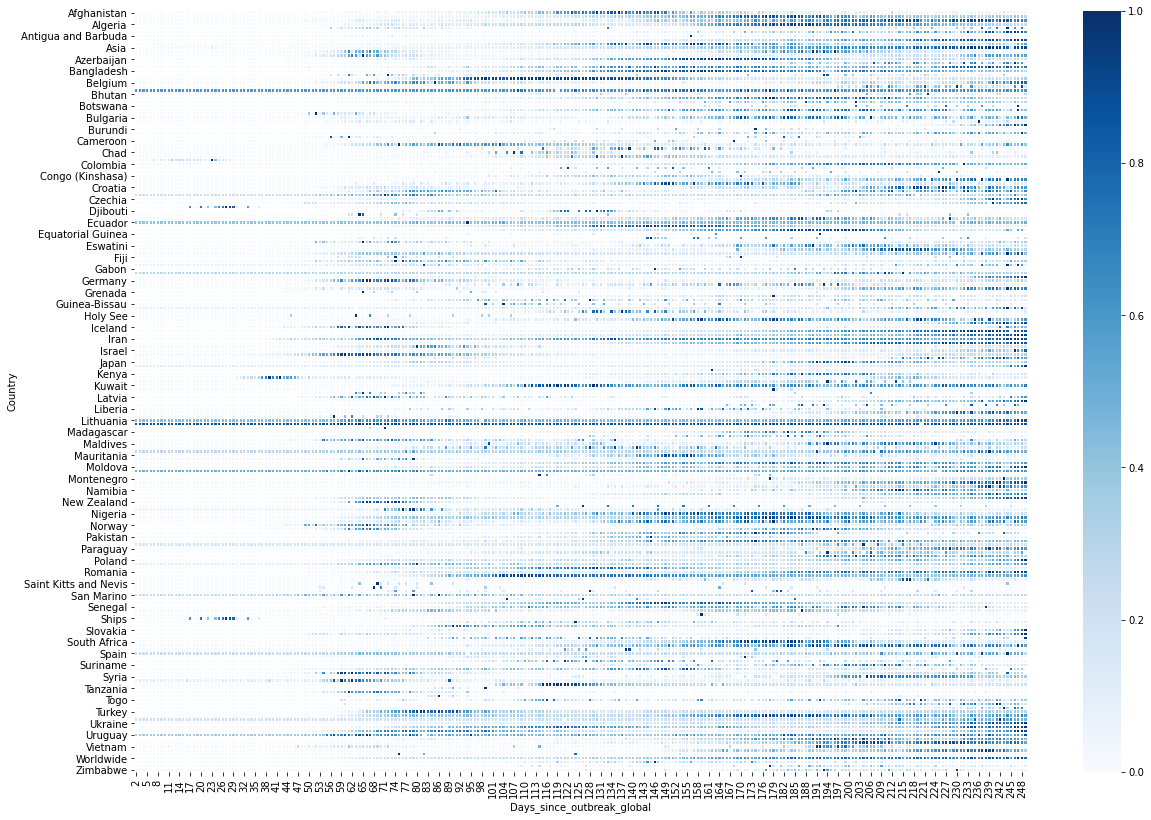

In [40]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

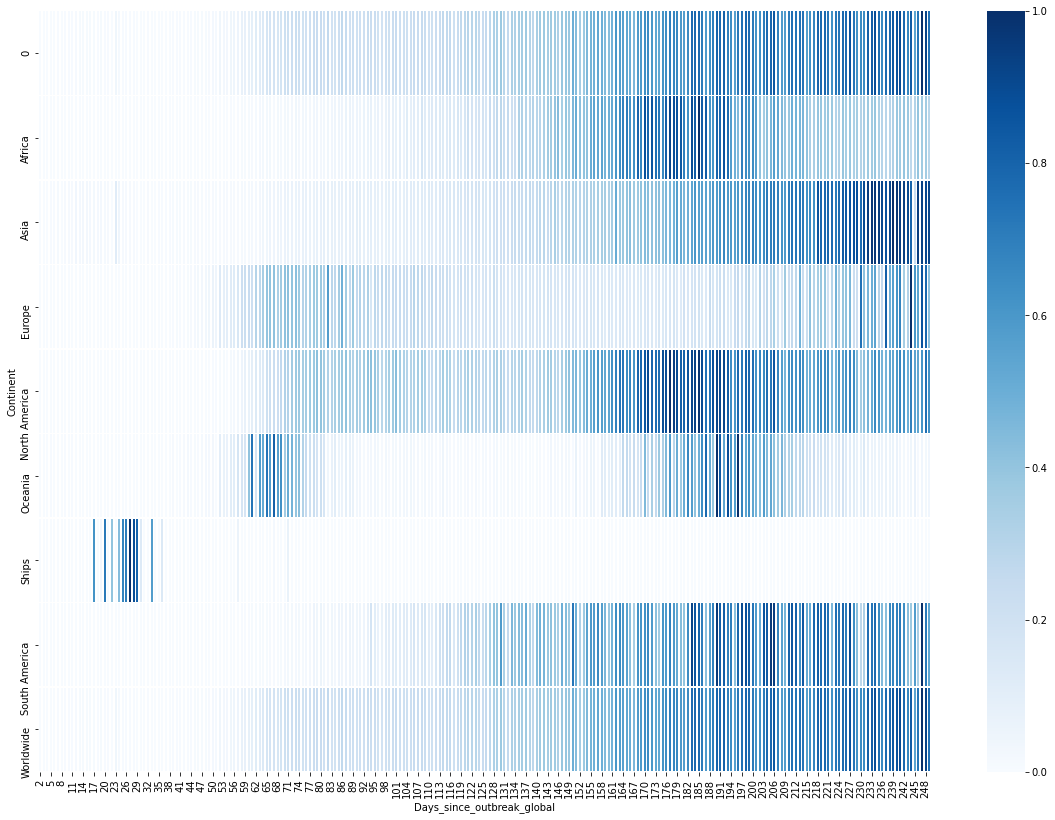

In [41]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

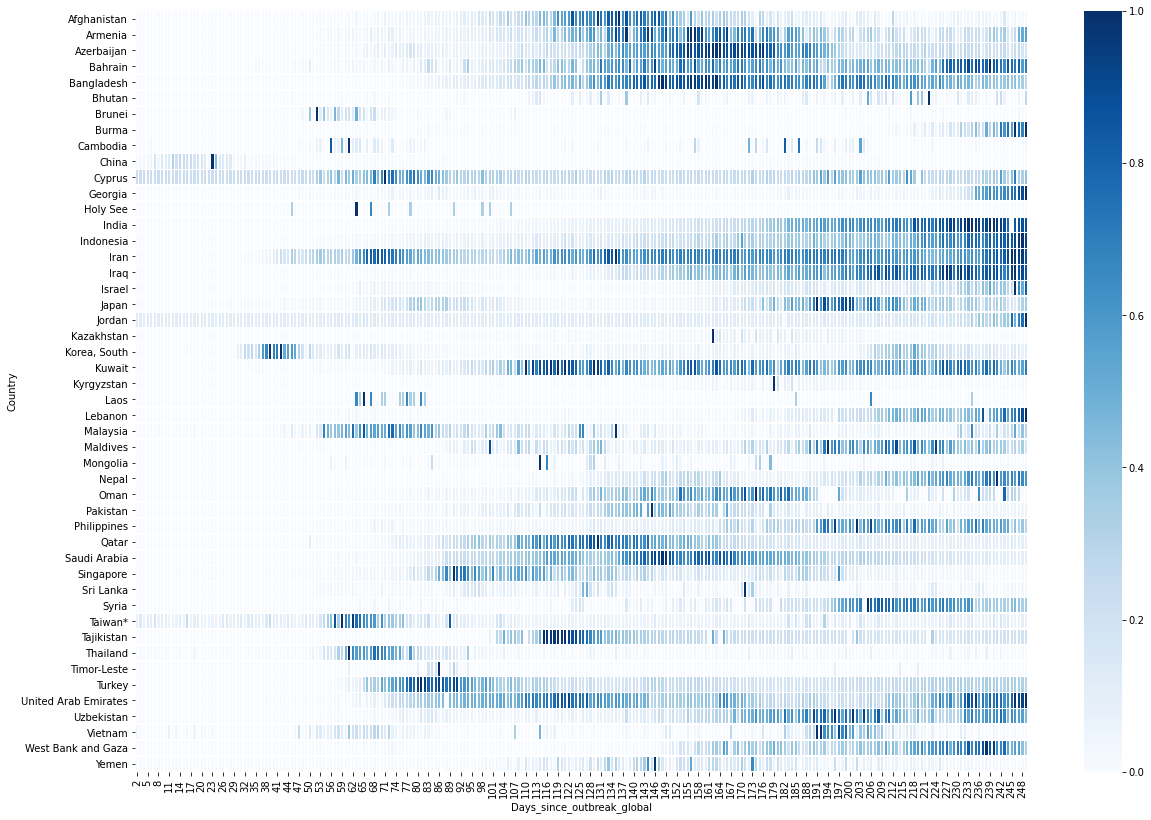

In [42]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

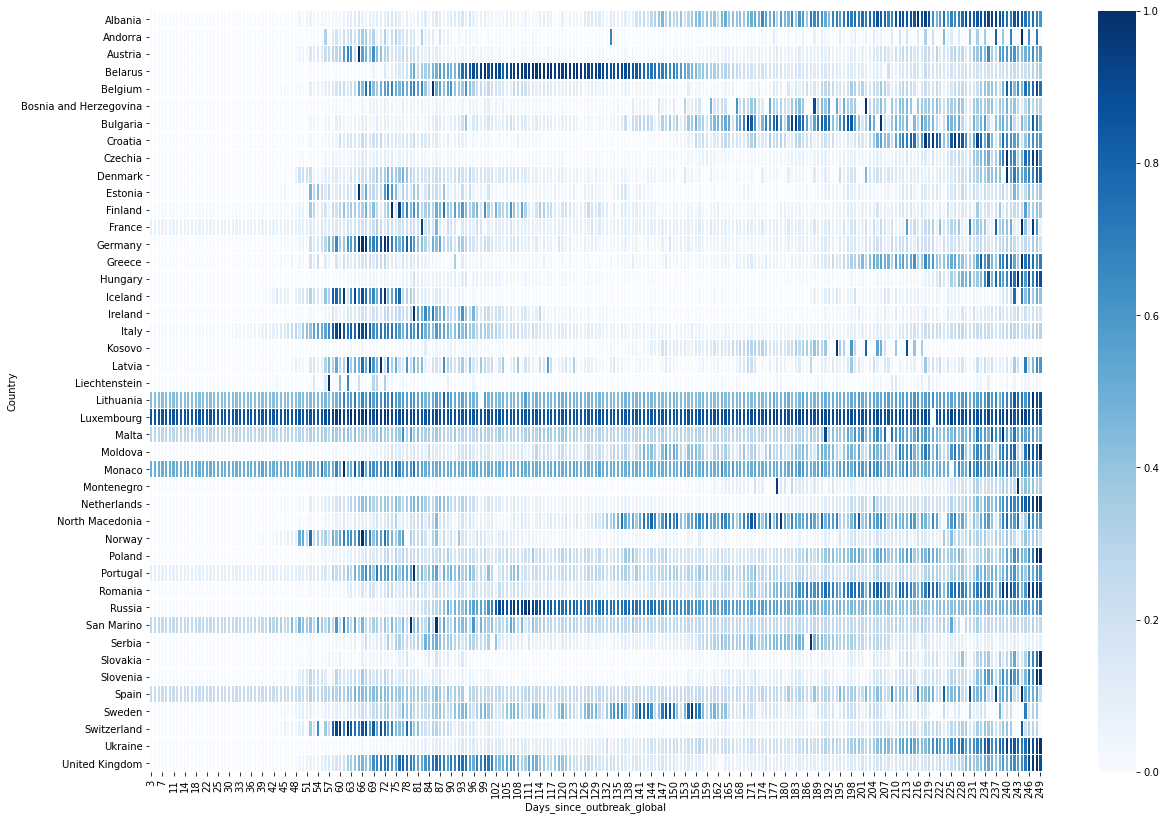

In [43]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

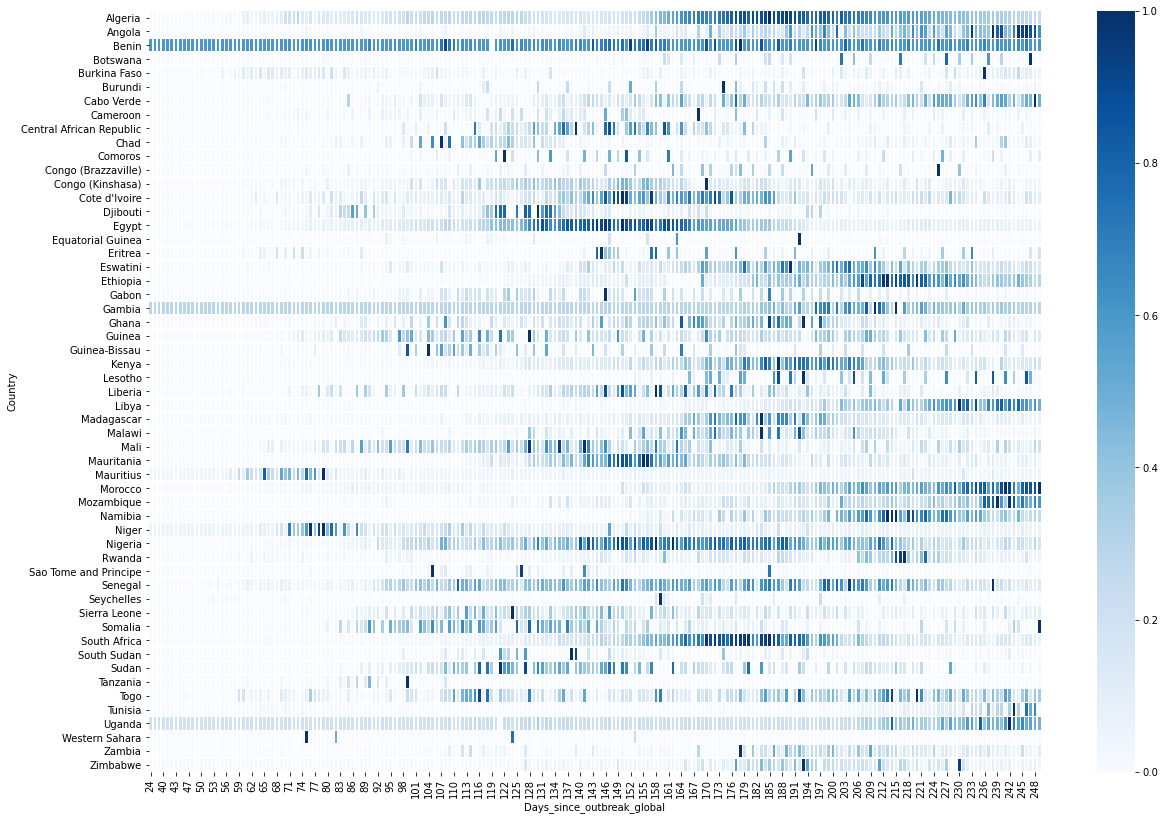

In [44]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

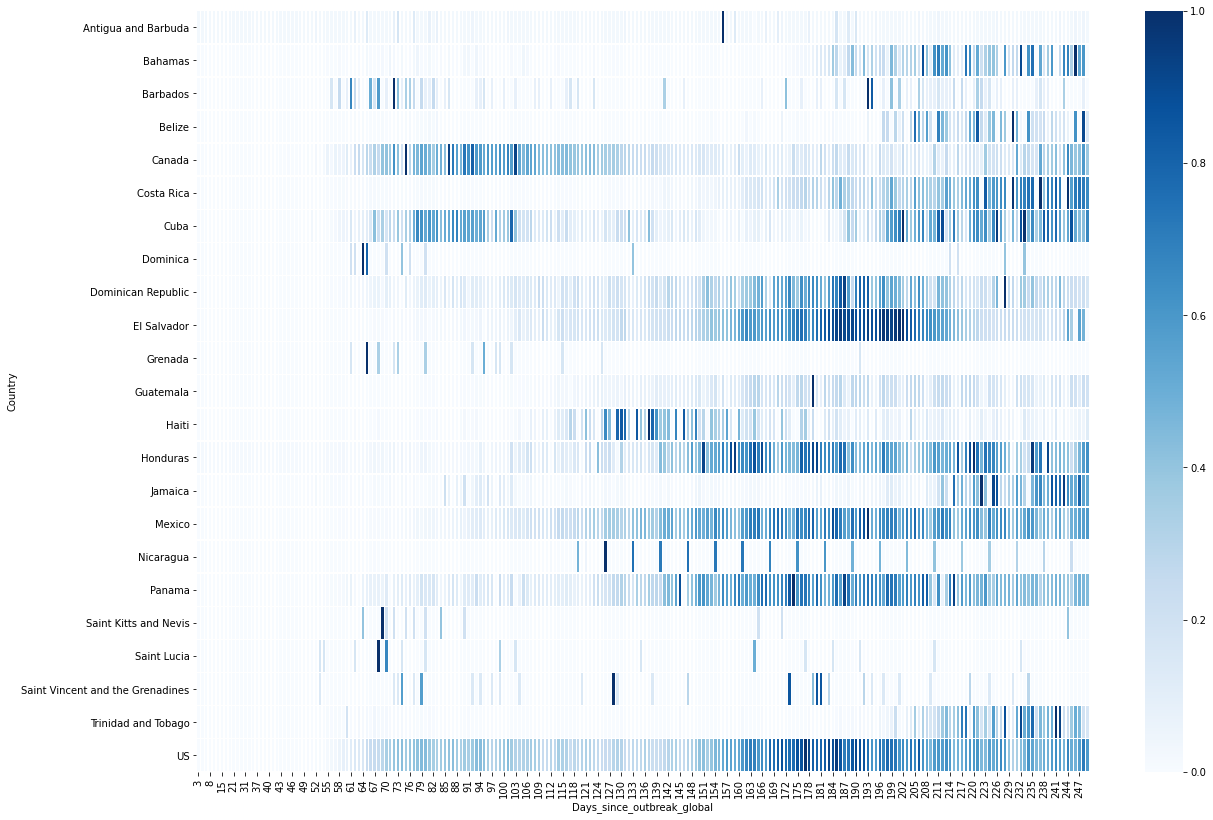

In [45]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

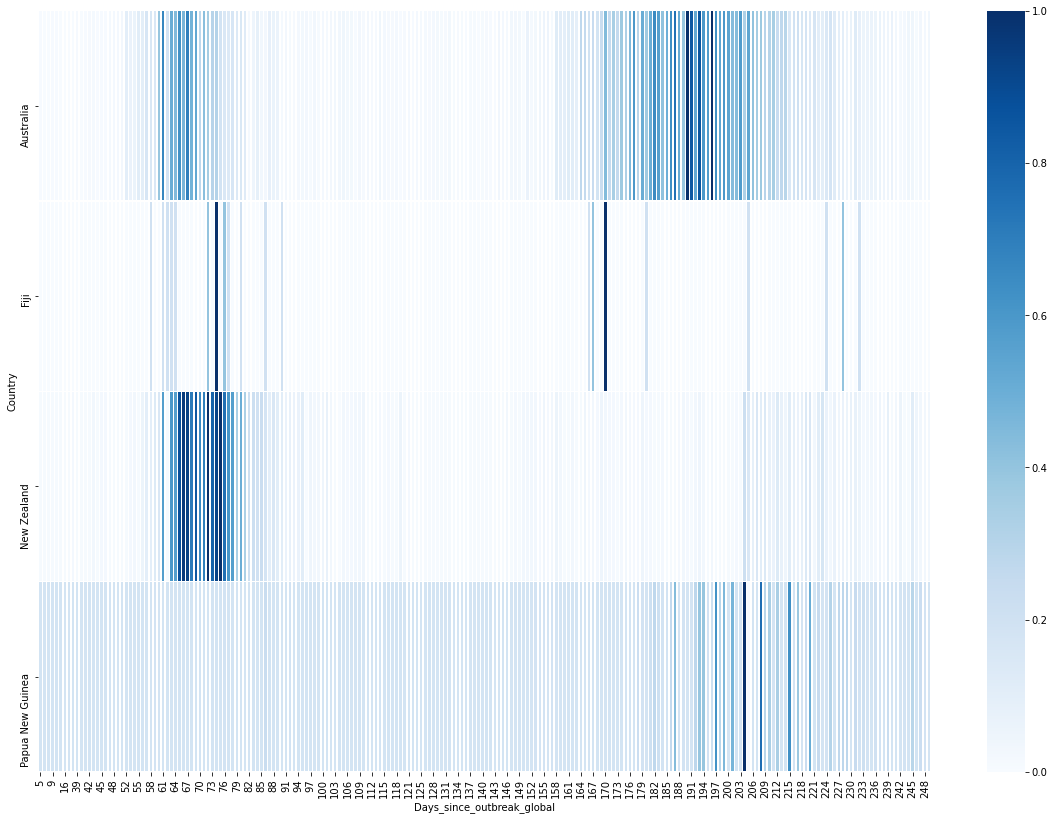

In [46]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

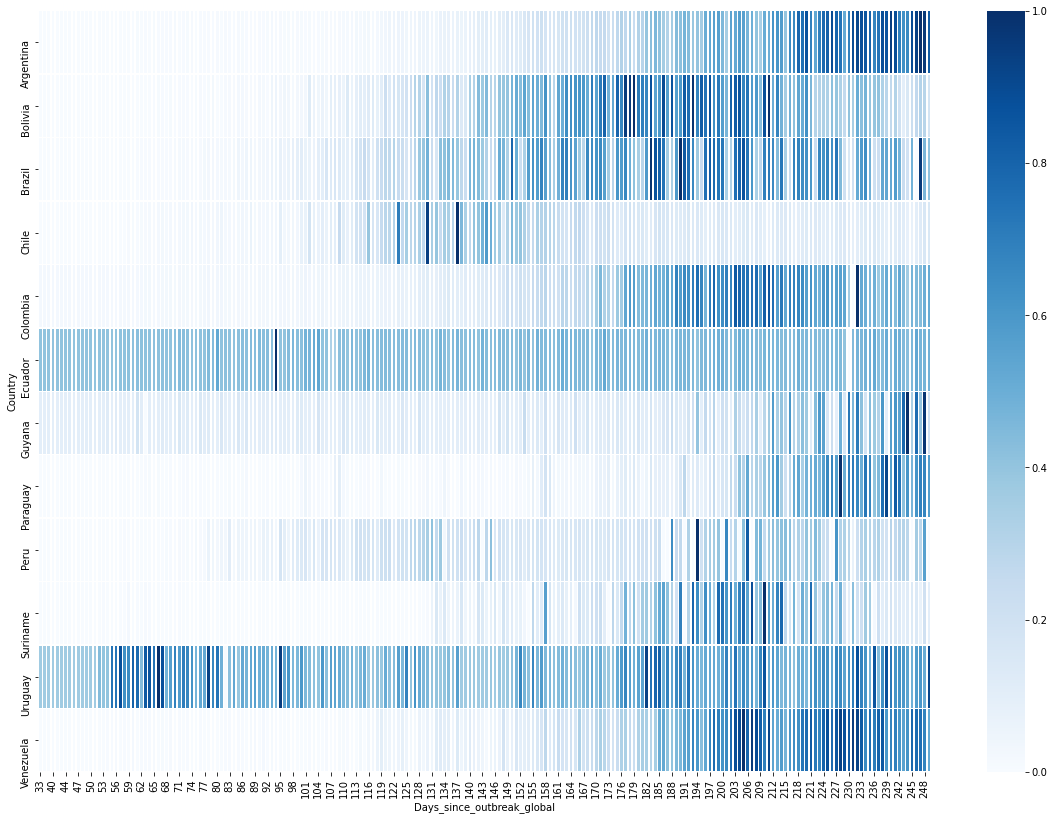

In [47]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

In [62]:
rcParams['figure.figsize'] = 15, 5

## Prediction

In [63]:
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]

In [64]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [65]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 9, 19, 11, 0, 38, 620738)

In [66]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [67]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

32936.19792013137
44862.439445560616
0.17453374590158868


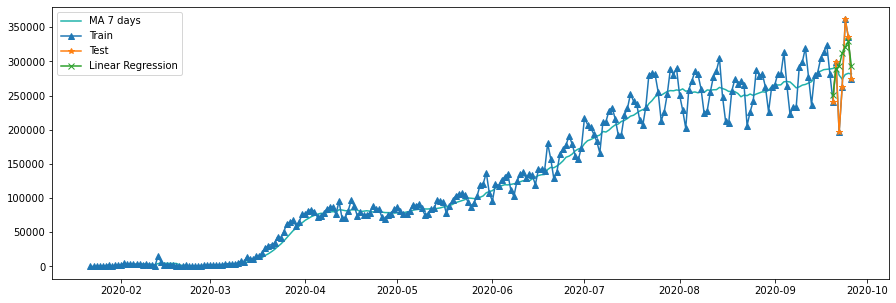

In [80]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Worldwide")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X_train, y_train)

Confirmed_test['File_type'] = "Test"
Confirmed_train['File_type'] = "Train"

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
Combined = Confirmed_train.append(Confirmed_test)
Combined['MA_7_d'] = Combined['Confirmed'].rolling(window=7).mean()

plt.plot(Combined.index, Combined['MA_7_d'], label='MA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Combined.index, Combined['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

385.75906929458444
457.44417331380305
0.28107036679534086


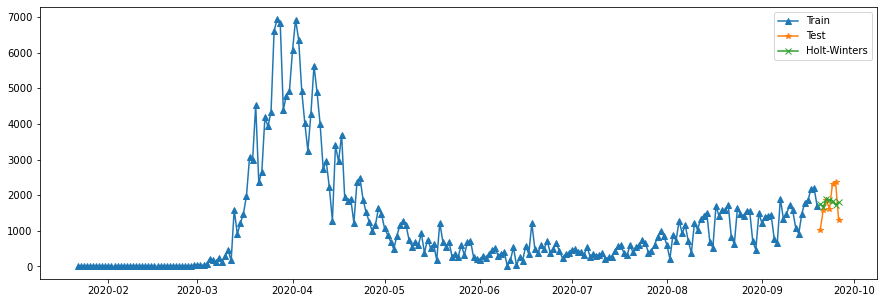

In [69]:
#Holt winters-non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

['add', True, 'add', 6, False, False]
385.03700538492154
451.78578430700475
0.27950742851542776


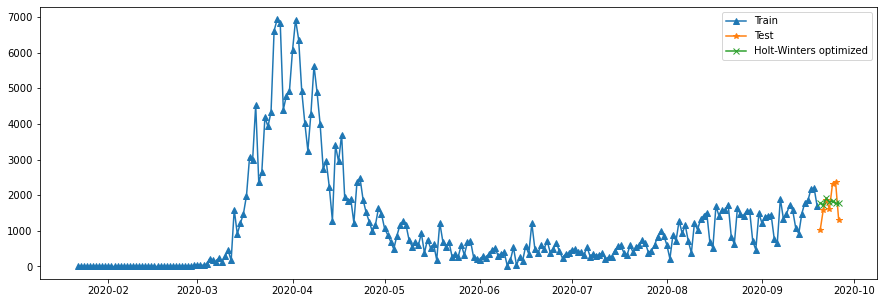

In [70]:
#Holt Winters optimized
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs()

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    try:
        cg = cfg_list[j]
        t,d,s,p,b,r = cg

        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

        pred = hw_model.predict(start=test.index[0], end=test.index[-1])

        pred = pd.DataFrame(pred)
        pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)
        
        rmse = np.sqrt(mean_squared_error(y_pred=pred, y_true=test))
        
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

t1,d1,s1,p1,b1,r1 = best_config
print(best_config)

if t1 == None:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

358.04593978778183
431.7940992928598
0.2591892201026014


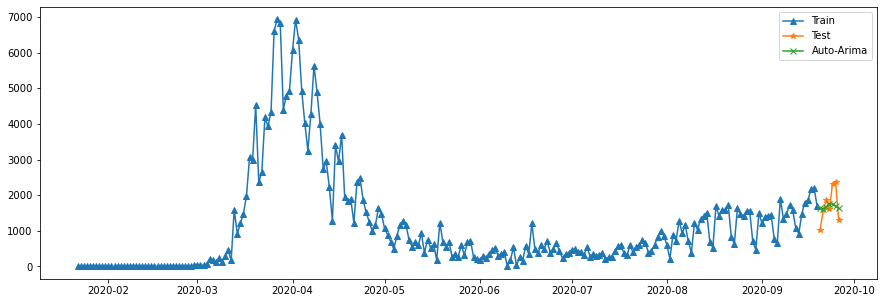

In [71]:
#Auto-Arima
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

276.8728550502232
294.11190656806923
0.17089043815661994


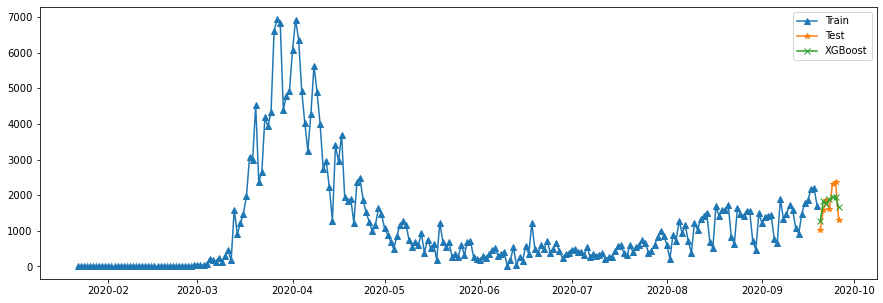

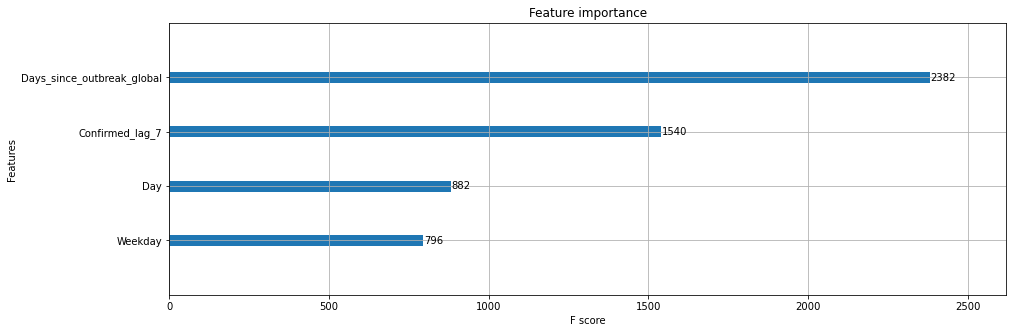

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [72]:
#XGBoost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

100%|██████████████████████████████████████████████| 100/100 [00:08<00:00, 11.29trial/s, best loss: 189.19845145089286]
189.19845145089286
211.00707883459066
0.12433510756226905


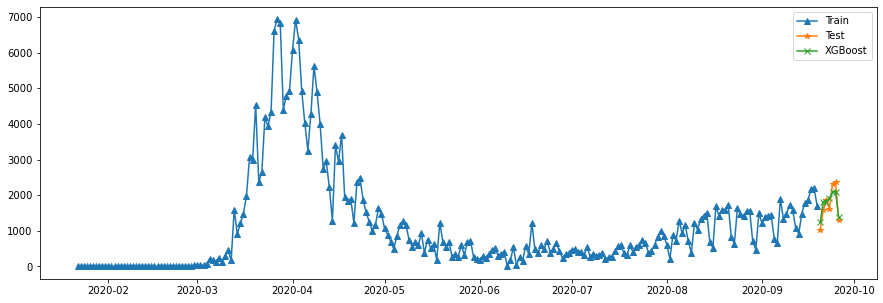

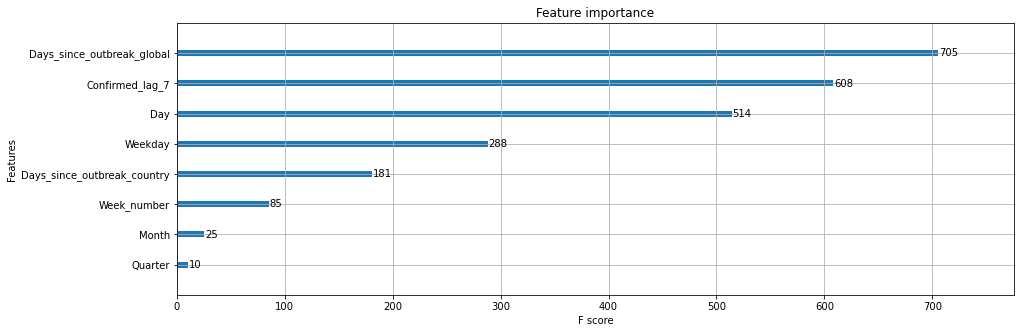

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6017213792577853, 'gamma': 3.827067582958003, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 4.0, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 40, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [73]:
#XGBoost Optimized
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 500,5000,500),
    }

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

def hyperparameter_tuning(space):
    reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')
        
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
            early_stopping_rounds=200,verbose=False)

    pred = reg.predict(X_test)
    mae= mean_absolute_error(y_pred=pred, y_true=y_test)
    #change the metric if you like
    clear_output(wait=True)
    return {'loss':mae, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                         reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                         colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

307.74910441585143
353.2759070492266
0.20012030316615892


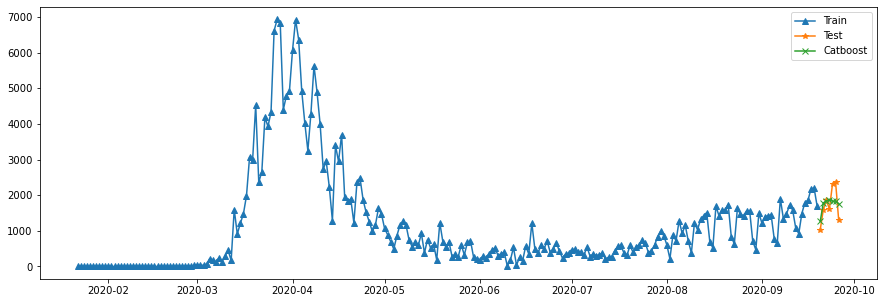

In [74]:
#Catboost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = CatBoostRegressor(iterations=1000, verbose=False, loss_function='RMSE')
# Fit model
model.fit(X_train, y_train,plot=True, eval_set=(X_test, y_test))

Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Catboost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


878.1480208424624
923.5002208677101
0.7134106537109546


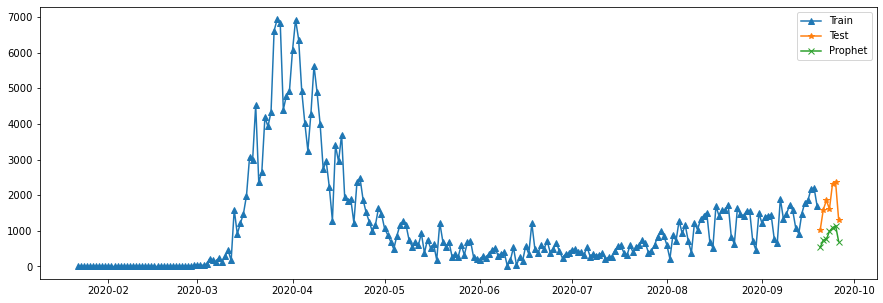

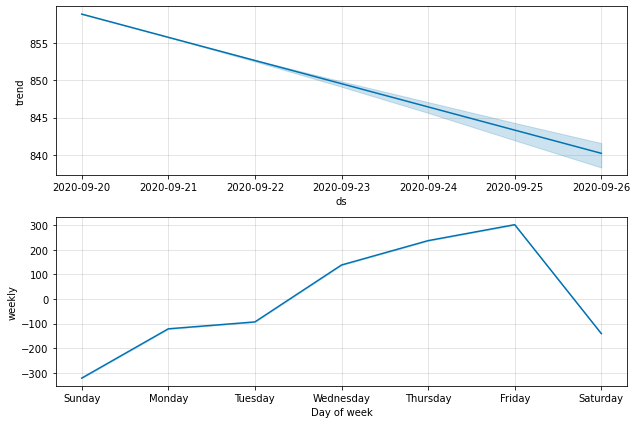

In [75]:
#Prophet
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

#pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))
pred = pd.DataFrame(model.predict(df=test.reset_index().rename(columns={'Date':'ds'})))

#pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.yhat))

fig = model.plot_components(pred)

### All customers

In [76]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Canada_Diamond Princess")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)
len(df_ml_confirmed_var)

274

#### Linear Regression

In [77]:
Train_and_Test = []

In [78]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [81]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

618.5535947262211
848.3861040057092
0.8131324490610379


#### Holt-Winters (non-optimized)

In [82]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [83]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSLE.notnull(), 'RMSLE']))

752.317741542589
973.0177379475041
0.7323777842693138


#### Holt-Winters (optimized)

In [85]:
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

In [86]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = p1 = b1 = r1 = ''
    for j in range(len(cfg_list)):
        try:
            cg = cfg_list[j]
            t,d,s,p,b,r = cg

            model = ExponentialSmoothing(Confirmed_train_, trend=t, damped=d, seasonal=s, seasonal_periods=p)

            hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

            Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])

            rmse = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except:
            continue

    t1,d1,s1,p1,b1,r1 = best_config

    if t1 == None:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1)
    else:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

    hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [87]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSLE.notnull(), 'RMSLE']))

690.5120178213672
929.3039615008599
0.7166276346627277


#### Auto-ARIMA

In [88]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                          suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [89]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSLE.notnull(), 'RMSLE']))

610.520406270258
851.2647877851214
0.7307403768182923


#### XGboost (non-optimized)

In [90]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Non-optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost)


Finished!


In [91]:
Train_and_Test_XGBoost = Train_and_Test_XGBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSLE.notnull(), 'RMSLE']))

595.6847770706798
790.4316943783253
0.5884619901707593


#### XGboost (optimized)

In [92]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    def hyperparameter_tuning(space):
        reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                             reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
                early_stopping_rounds=200,verbose=False)

        pred = reg.predict(X_test)
        mae= mean_absolute_error(y_pred=pred, y_true=y_test)
        #change the metric if you like
        clear_output(wait=True)
        return {'loss':mae, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                             reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                             colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost_optimized)


100%|██████████████████████████████████████████████| 100/100 [00:08<00:00, 12.32trial/s, best loss: 12189.931919642857]

Finished!


In [93]:
Train_and_Test_XGBoost_optimized = Train_and_Test_XGBoost_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSLE.notnull(), 'RMSLE']))

524.8971253558605
737.1700779691365
0.5557845116089949


#### CatBoost

In [94]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    try:
    
        List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]

        Confirmed_train = List.loc[List.Date <= split_date].copy()
        Confirmed_test = List.loc[List.Date > split_date].copy()

        X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
        X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        model = CatBoostRegressor(iterations=1000, verbose=False)
        model.fit(X_train, y_train)

        Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

        Confirmed_test['File_type'] = "Test"
        Confirmed_train['File_type'] = "Train"

        Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)

        Train_and_Test_['Model'] = 'CatBoost'

        Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

        Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

        Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])

        Train_and_Test_temp.append(Train_and_Test_)
        
    except Exception as e: 
        pass
    
print("Finished!")

Train_and_Test_CatBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_CatBoost)


Finished!


In [95]:
Train_and_Test_CatBoost = Train_and_Test_CatBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSLE.notnull(), 'RMSLE']))

560.507534127667
811.2061129637691
0.6691766346056092


#### Prophet

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)
    
    Confirmed_train_ = Confirmed_train[['Confirmed','Date']]
    Confirmed_test_ = Confirmed_test[['Confirmed','Date']]

    model = Prophet()
    model.fit(Confirmed_train_.reset_index(drop=True).rename(columns={'Date':'ds', 'Confirmed':'y'}))

    Confirmed_pred = model.predict(df=Confirmed_test_.reset_index(drop=True).rename(columns={'Date':'ds'}))
    
    Confirmed_test.index.name = None
    Confirmed_test = pd.merge(Confirmed_test, Confirmed_pred[['ds','yhat']], left_on='Date', right_on='ds', how='left').rename(columns={'yhat':'Confirmed_Prediction'}).drop(columns=['ds'])
            
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Prophet"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Prophet = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Prophet)

In [97]:
Train_and_Test_Prophet = Train_and_Test_Prophet.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSLE.notnull(), 'RMSLE']))

841.3850016358753
1048.5574994905242
0.9052321700505754


#### Final Steps

In [98]:
Train_and_Test['Update_date'] = datetime.today()

In [99]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [100]:
Train_and_Test.to_excel('Train_and_Test.xlsx', index = False)